In [1]:
%matplotlib inline
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import matplotlib
import time
import datetime
import pandas
import numpy
import scipy.stats
import abcutils

## Global Analysis Constants

In [4]:
TEST_PLATFORMS = [
    'scratch1@edison',
    'scratch2@edison',
    'scratch3@edison',
    'cscratch@cori-knl',
    'cscratch@cori-haswell',
    'mira-fs1@mira'
]

## Load and Synthesize Data from CSV

In [5]:
df = pandas.concat([abcutils.load_and_synthesize_csv('summaries/edison-summaries_2017-02-14-2017-12-30.csv', system='edison'),
                    abcutils.load_and_synthesize_csv('summaries/cori-summaries_2017-02-14-2017-12-31.csv', system='cori'),
                    abcutils.load_and_synthesize_csv('summaries/alcf-tokio-results-2_14_17-2_15_18.csv', system='mira')],
                   axis='rows')
df['fs_tot_bytes_io'] = df['fs_tot_bytes_read'] + df['fs_tot_bytes_written']

In [18]:
test_platform = 'cscratch@cori-knl'
benchmark_id = 'ior_fpp_write'
l_plot_metric = 'darshan_normalized_perf_by_max'
b_plot_metric = 'fs_tot_bytes_io'
date_start = datetime.datetime(2017, 2, 14)
date_end = date_start + datetime.timedelta(days=365)
group_by = [ '_test_platform', '_benchmark_id' ]

filtered_df = df.groupby(by=group_by).get_group((test_platform, benchmark_id))
filtered_df = filtered_df[filtered_df['_datetime_start'] < date_end]
filtered_df = filtered_df[filtered_df['_datetime_start'] >= date_start]

In [19]:
def timeseries_smaplot(dataframe, plot_metric, date_start, date_end, window=10, ax=None, **kwargs):
    x, y, x_labels = abcutils.plot.distribution_over_time(dataframe, plot_metric, date_start, date_end, datetime.timedelta(days=1))
    
    # bin up & convert to df
    agg_y = []
    for day in y:
        agg_val = 0
        samples = 0
        for val in day:
            agg_val += val
            samples += 1
        if samples > 0:
            agg_y.append(agg_val/samples)
        else:
            agg_y.append(None)
    df_y=pandas.Series(agg_y)
    
    y_sma = df_y.rolling(window=window,min_periods=1,center=True).mean()
#    with pandas.option_context('display.max_rows', None, 'display.max_columns', 3):
#        print(y_sma)

    ax.plot(x, y_sma, linestyle='-', label=str(window)+'-day sma', **kwargs)

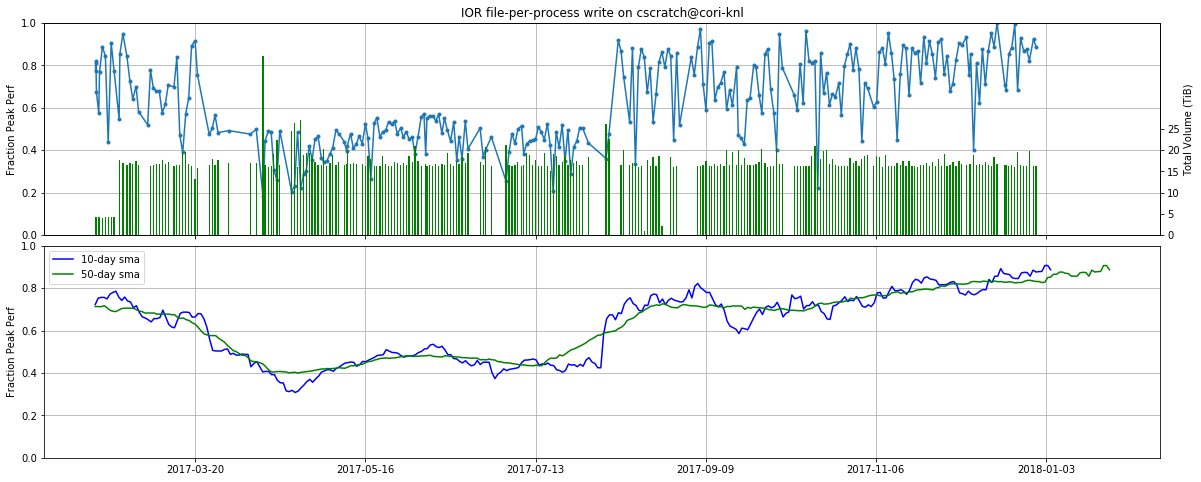

In [24]:
fig, axes = matplotlib.pyplot.subplots(nrows=2, ncols=1, sharex=True)
fig.set_size_inches(20,8)

x_raw = filtered_df['_datetime_start'].apply(lambda x: time.mktime(x.timetuple()))
l_y_raw = filtered_df[l_plot_metric]
b_y_raw = filtered_df[b_plot_metric]

ax = axes[0]
ax.plot(x_raw, l_y_raw, linestyle='-', marker='.')
ax.grid()
ax.set_title("%s on %s" % (abcutils.CONFIG['benchmark_labels'].get(benchmark_id, benchmark_id),
                           test_platform))
ax.set_xticklabels([datetime.datetime.fromtimestamp(x).strftime("%Y-%m-%d") for x in ax.get_xticks()])
ax.set_ylim(0, 1)
ax.set_ylabel(abcutils.CONFIG['metric_labels'].get('darshan_normalized_perf_by_max', 'darshan_normalized_perf_by_max'))

ax2 = ax.twinx()
ax2.bar(x_raw.values, b_y_raw, width=(60*60*10), **{'color': 'green'})
ax2.set_ylim(0, (50*1024*1024*1024*1024))
ax2.set_ylabel('Total Volume (TiB)')
yticks = [(i*1024*1024*1024*1024) for i in numpy.arange(0, 30, 5)]
ax2.set_yticks([(i*1024*1024*1024*1024) for i in numpy.arange(0, 30, 5)])
ax2.set_yticklabels(numpy.arange(0, 30, 5))

ax = axes[1]
timeseries_smaplot(filtered_df, l_plot_metric, date_start, date_end, 10, ax=ax, **{'color': 'blue'})
timeseries_smaplot(filtered_df, l_plot_metric, date_start, date_end, 50, ax=ax, **{'color': 'green'})
#timeseries_smaplot(filtered_df, l_plot_metric, date_start, date_end, 100, ax=ax, **{'color': 'red'})
ax.grid()
ax.set_ylim(0, 1)
ax.set_ylabel(abcutils.CONFIG['metric_labels'].get('darshan_normalized_perf_by_max', 'darshan_normalized_perf_by_max'))
ax.get_figure().subplots_adjust(hspace=0.05, wspace=0.05)
ax.legend()

pass